# Part 1 - Reading in the data

## Part 1.1

In [442]:
# Libraries used for data handling, plotting and calculations
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [443]:
def importing_csvs(name_prefix, filetype, sep, date_col):
    """
    Import all files matching {name_prefix}*.{filetype} in data_path_ and return a concatenated DataFrame.
    
    Parameters:
    - name_prefix (str): The prefix of the file names to match.
    - filetype (str): The file extension/type (e.g., 'csv').
    - sep (str): The separator used in the CSV files.
    - date_col (str): The name of the column to parse as dates.
    
    Returns a pandas DataFrame containing the concatenated data from all matched files.
    
    """

    # Define the file pattern, with a wildcard after the name_prefix
    pattern = f'./data/{name_prefix}*.{filetype}'

    # Initialize an empty list to hold DataFrames
    dfs = []

    # Loop through files matching the file pattern and read them into DataFrames
    # Append each DataFrame to the list named dfs
    # Parse the date_col as dates and use the specified separator
    for fp in glob.glob(pattern):
        d = pd.read_csv(fp, parse_dates=[date_col], sep=sep)
        dfs.append(d)

    # Safety check: if no files matched, return an empty DataFrame instead of error message
    if not dfs:
        print(f'No files matched pattern: {pattern}')
        return pd.DataFrame()

    # Concatenate all DataFrames into a single DataFrame named df_output
    df_output = pd.concat(dfs, ignore_index=True)

    # Return the concatenated DataFrame
    return df_output

In [444]:
df_original = importing_csvs('SCE', 'csv', ';', 'date')

## Part 1.2

In [445]:
# Function to compute and print overview statistics
# Using this for original DataFrame and cleaned DataFrame later
def overview_stats(data):

    # Finding number of unique users
    unique_ids = data['userid'].nunique()
    print(f'Number of unique users: {unique_ids}')

    # Finding number of data rows
    data_rows = data.shape[0]
    print(f'Number of data rows: {data_rows}')

    # Finding number of unique waves
    unique_waves = data['wid'].nunique()
    print(f'Number of unique waves: {unique_waves}')

    # Finding date range
    first_date = data['date'].min()
    last_date = data['date'].max()

    # Printing first and last dates observed
    print(f'Data ranges from {first_date.date()} to {last_date.date()}')
    
    # No return value, since we are just printing the statistics
    return None

In [446]:
# Using the function to get overview statistics of the original DataFrame
overview_stats(df_original)

Number of unique users: 23369
Number of data rows: 176101
Number of unique waves: 139
Data ranges from 2013-06-01 to 2024-12-31


# Part 2

## Part 2.1

In [447]:
# Sort by 'userid' and 'date'
# Creating new dataframe (df) to avoid modifying original dataframe (df_original)

# Sorting and ensuring 'date' is datetime
# Setting 'userid' as index for grouping
df = df_original.sort_values(["userid", "date"], ignore_index=True)

# Could have looped through columns but this is clearer
num_cols = [c for c in df.columns if "num_lit_" in c and "_correct" in c]

# Fill missing values with the first observed value per user
# Using lambda function to forward-fill and backward-fill missing values
df[num_cols] = (
    df.groupby("userid", group_keys=False)[num_cols]
      .apply(lambda g: g.ffill().bfill())
)

## Part 2.2 (Need improvements)

In [448]:
# Dropping rows with missing values in specified subsets of columns

# Demographic columns: age, gender, education
demo = ['age', 'female', 'educ']
# Expectation columns: inflation, changes in house prices and the probability of the stock market increasing 
expectation = ['inflation', 'house_price_change', 'prob_stocks_up']

# Define subsets and drop NAs accordingly
subsets = [
    ("demo", demo),
    ("expectation", expectation),
    ("numeracy", num_cols)              # num_cols defined in previous cell
]

# Initialize total dropped rows counter
total_rows_dropped = 0

# Loop through subsets and drop rows with NAs
for name, ss in subsets:
    # Get number of rows before dropping NAs
    before = df.shape[0]

    # Drop rows with NAs in the specified subset of columns
    df = df.dropna(subset=ss, ignore_index=True)

    # Get number of rows after dropping NAs
    after = df.shape[0]
    # Update total dropped rows
    total_rows_dropped += (before - after)
    
    print(f"Numbers before dropping NAs for {name}: {before}, after: {after}, dropped: {before - after}")

print(f'\nTotal rows dropped: {total_rows_dropped}')

Numbers before dropping NAs for demo: 176101, after: 175233, dropped: 868
Numbers before dropping NAs for expectation: 175233, after: 173550, dropped: 1683
Numbers before dropping NAs for numeracy: 173550, after: 137576, dropped: 35974

Total rows dropped: 38525


## Part 2.3

In [449]:
def drop_outliers(data, columns):
    """
    Function to drop outliers  based on the 0.1th and 99.9th percentiles.
    Parameters:
    - data: The input DataFrame from which to drop outliers.
    - columns: List of column names to check for and drop outliers.

    """
    
    total_outliers_dropped = 0
    # Loop through each specified column to calculate and drop outliers
    for col in columns:

        # Calculate percentiles and find number of rows before dropping
        before = data.shape[0]
        # Calculate 0.1th percentile
        low = data[col].quantile(0.001)
        # Calculate 99.9th percentile
        high = data[col].quantile(0.999)

        # Filter data to keep only rows within the percentile range, and calculate number of dropped rows
        data = data.query(f"{col} > {low} and {col} < {high}")
        # Calculate number of dropped rows
        dropped = before - data.shape[0]
        total_outliers_dropped += dropped

        print(f"{col.capitalize()}: 0.1th percentile = {low}, 99.9th percentile = {high}")
        print(f"Observations dropped for {col}: {dropped}\n")
    
    print(f'Total outliers dropped: {total_outliers_dropped}')
    # Return the cleaned data without outliers
    return data

In [450]:
# Using the function to drop outliers in expectation variables
df = drop_outliers(df, expectation)

Inflation: 0.1th percentile = -75.0, 99.9th percentile = 100.0
Observations dropped for inflation: 434

House_price_change: 0.1th percentile = -50.0, 99.9th percentile = 100.0
Observations dropped for house_price_change: 418

Prob_stocks_up: 0.1th percentile = 0.0, 99.9th percentile = 100.0
Observations dropped for prob_stocks_up: 2456

Total outliers dropped: 3308


## Part 2.4

In [451]:
# Creating a dummy variable for bachelors degree
df['college'] = (df['educ'] == 4).astype(int)

## Part 2.5

In [452]:
# Calculate number of correct answers per user
num_correct = df.groupby("userid")[num_cols].first().sum(axis=1)

# value counts normalized to fractions
fraction = num_correct.value_counts(normalize=True).sort_index() * 100

# display results
summary = fraction.rename("percent").reset_index().rename(columns={"index": "num_correct"})
print(round(summary, 1))

   num_correct  percent
0          0.0      0.1
1          1.0      0.7
2          2.0      2.4
3          3.0      5.7
4          4.0     10.5
5          5.0     16.9
6          6.0     27.4
7          7.0     36.3


In [453]:
# Create a new column num_lit_high (“high numerical literacy”) equal to 1 if an individual had
# More correct responses than the median, and 0 otherwise."

# Calculate the median number of correct responses
median_num_correct = num_correct.median()
# Create the num_lit_high column with a dummy variable if a user had more correct responses than the median
num_lit_high = (num_correct > median_num_correct).astype(int)

# Add it to the dataframe by userid
df['num_lit_high'] = df['userid'].map(num_lit_high)

## Part 2.6

In [454]:
#Use function to print overview statistics of cleaned data
overview_stats(df)

Number of unique users: 17598
Number of data rows: 134268
Number of unique waves: 117
Data ranges from 2015-04-02 to 2024-12-31


# Part 3: 
Do average expectations of inflation, house prices, and stock markets differ across gender, education, and numeracy (or numerical literacy, the ability to perform simple numerical tasks)?

## Part 3.1

In [455]:
def analyze_expectations_by_group(data, group_var, group_labels):
    """
    Calculate average expectations by group.
    
    Parameters:
    - data: DataFrame containing the data
    - group_var: string, column name for grouping ('female', 'college', 'num_lit_high')
    - group_labels: tuple of strings for group labels
    
    """
    # Calculate means for each expectation variable by group
    means = data.groupby(group_var)[expectation].mean()
    
    # Rename index values to more descriptive labels
    means.index = group_labels
    
    # Round to 2 decimal places for cleaner output
    means = means.round(1)
    
    # Return means for further use
    return means

In [456]:
def plot_expectations_by_group(data, group_var, group_labels, title):
    """
    Create bar plots of expectations by group with specific y-axis ranges.
    
    """
    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(13, 5))
    fig.suptitle(f'{title}', fontsize=16, weight='bold')

    # Define y-axis ranges for each expectation variable
    ylims = {
        'inflation': (0, 15),
        'house_price_change': (0, 15),
        'prob_stocks_up': (0, 100)
    }

    # Use the analyze_expectations_by_group function to get means for all expectation vars
    means_df = analyze_expectations_by_group(data, group_var, group_labels)

    # Loop through each expectation variable to create individual bar plots
    for i in range(3):
        expectation_var = expectation[i]

        # Extract the series of means for the current expectation variable
        means = means_df[expectation_var]

        # Create bar plot for the current expectation variable and set title
        axes[i].bar(group_labels, means.values, color=['darkblue', 'salmon'])
        axes[i].set_title(expectation_var.replace('_', ' ').capitalize())

        # Set y-axis labels and limits
        axes[i].set_ylabel('Expectation (%)' if i < 2 else 'Probability (%)')

        # Set specific y-axis range for the expectation variable (e.g., inflation...)
        axes[i].set_ylim(ylims[expectation_var])  

        # Show values on top of bars. Uses enumarate to return both index and value for each item
        # n is index of the bar while value is the height of the bar
        for n, value in enumerate(means.values):
            axes[i].text(n,                                                    # x-coordinate
                        value + (ylims[expectation_var][1] * 0.02),            # y-coordinate relative to y-lim
                        f'{value}%',                                           # Text content
                        ha='center',                                           # Horizontal alignment to center
                        va='bottom')                                           # Vertical alignment to bottom

    plt.tight_layout()
    plt.show()

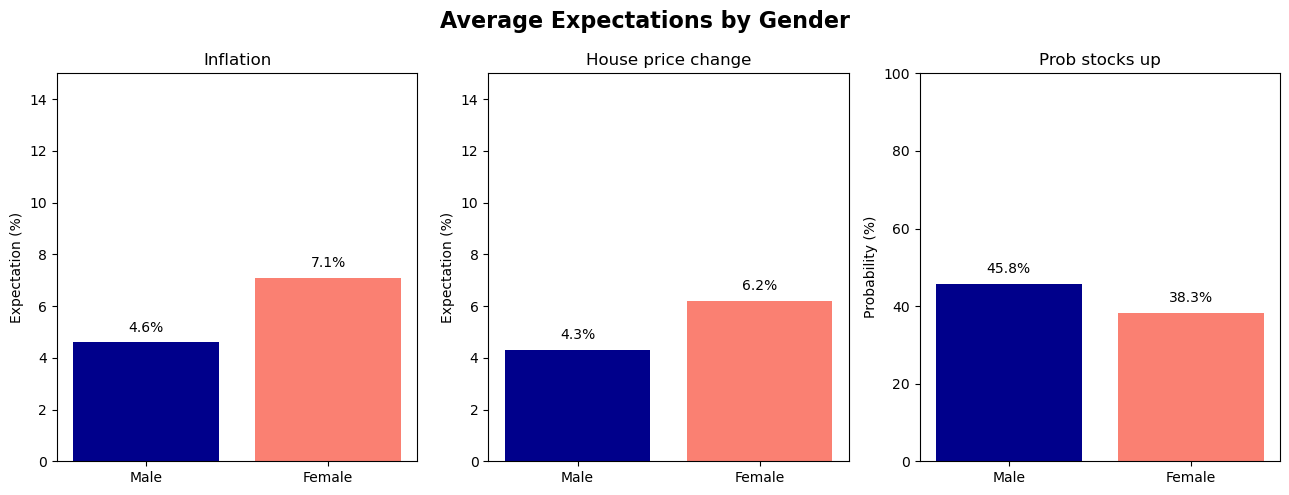

In [457]:
# Plot expectations by  
plot_expectations_by_group(df, 'female', ('Male', 'Female'), "Average Expectations by Gender")

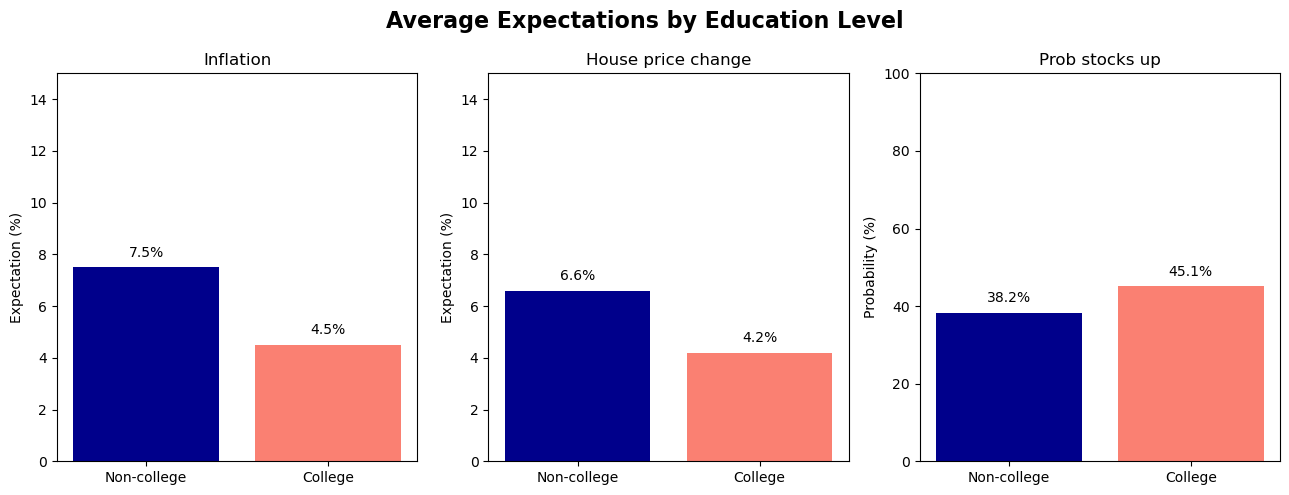

In [458]:
# Plot expectations by education level
plot_expectations_by_group(df, 'college', ('Non-college', 'College'), 'Average Expectations by Education Level')

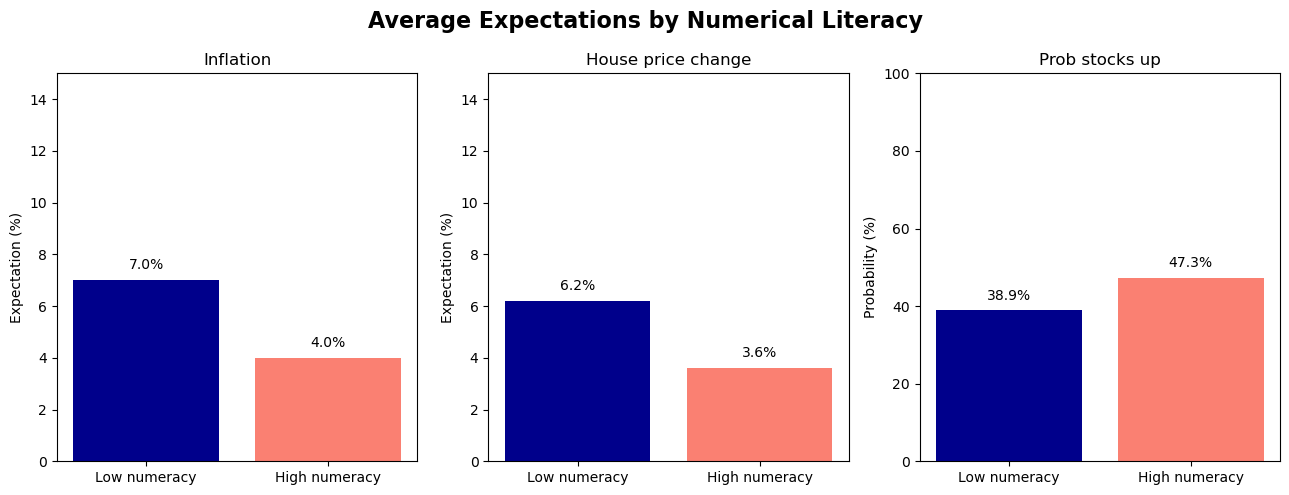

In [459]:
# Plot expectations by numerical literacy
plot_expectations_by_group(df, 'num_lit_high', ('Low numeracy', 'High numeracy'), 'Average Expectations by Numerical Literacy')

## Conclusion: Task 3 — How do expectations differ by gender, education, and numeracy?

The results reveal consistent differences in expectations across groups.

---

#### **Gender**
As shown in the graph, women expect around 7.4% inflation and 6.4% house price growth, compared to men's 4.9% and 4.3%, respectively. They also assign a lower probability (≈38%) that stocks will rise versus men (≈45%). This indicates that women are generally more concerned about rising prices and more cautious toward stock market risk.

#### **Education Level**
The graph shows that non-college respondents expect about 8% inflation and 7% house price growth, while college-educated individuals predict around 4.5% and 4%. College-educated respondents also expect a higher 45% probability that stocks will increase, compared to 38% for non-college participants. This suggests that higher education is linked to more moderate and economically grounded expectations.

#### **Literacy Level**
As shown in the graph, people with low numeracy expect around 7.5% inflation and 6.4% house price growth, while high-numeracy individuals expect only about 4% and 3.6%, respectively. This likely reflects that people with stronger numerical skills make more realistic, data-based judgments. Similarly, high-numeracy individuals see about a 47% chance of stock prices rising, compared to 39% for low numeracy, suggesting they better understand market probabilities.

---

### Summary

Overall, people with higher numeracy or education have more moderate and realistic expectations: lower predicted inflation and house price growth but higher confidence in the stock market. In contrast, those with lower numeracy, less education, or women expect higher prices and show more caution toward financial risk.

# Part 4
Do expectation dynamics over time differ across these groups, and how do important geopolitical
events affect these expectations?

## Part 4.1

In [460]:
def monthly_group_means(df, group_col, date_col="date"):
    """
    Calculates monthly averages of expectation variables for each group.

    Returns three DataFrames (infl, house, stock),
    each showing average values per group for each month (2015–2024).
    
    Parameters:
    - df: DataFrame containing the data
    - group_col: string, column name
    - date_col: string, column name for dates (default is "date")

    """

    # Keep only the relevant columns (date, group, and expectation variables)
    df_monthly = df[[date_col, group_col] + expectation].copy()

    # Convert date column to datetime format
    df_monthly[date_col] = pd.to_datetime(df_monthly[date_col])

    # Group by month and group value, then compute the mean of expectation columns
    # Using pd.Grouper to group by month end, and also group_col, then taking the average of each expectation variable
    gb = df_monthly.groupby([pd.Grouper(key='date', freq='ME'), group_col])[expectation].mean()

    # For each expectation variable, reshape so that:
    #   rows = months, columns = groups
    #   then limit the range to Jan 2015 – Dec 2024
    inflation, house_price, stock_prob = (
        gb[var].unstack(group_col).loc["2015-01":"2024-12"]         # Uses unstack to reshape 
        for var in expectation                                      # Loop through expectation variables
    )

    # Return the three DataFrames
    return inflation, house_price, stock_prob


## Part 4.2

In [461]:
def create_monthly_group_plot(df, group_col, group_labels, custom_title, date_col="date"):
    """
    Create the 3-panel monthly group means plot and return (fig, axes).
    Does not add event lines so they can be layered later.
    
    Parameters:
    - df: DataFrame containing the data
    - group_col: string, column name for grouping
    - group_labels: tuple of strings for group labels
    - custom_title: string for the overall plot suptitle
    - date_col: string, column name for dates (default is "date")
    
    """
    # Get monthly group means for each expectation variable by using previous function
    infl, house, stock = monthly_group_means(df, group_col, date_col)

    # Create figure with 3 vertical subplots, using gridspec to adjust spacing
    fig, axes = plt.subplots(3, 1, figsize=(14, 18), gridspec_kw={'hspace': 0.4})
    fig.suptitle(custom_title, fontsize=16, y=0.94, weight='bold')

    # Loop through each expectation variable to plot
    # Defining titles for each subplot
    for i, (data, title) in enumerate(
        zip([infl, house, stock], ["Expected Inflation in 12 Months", "Expected Change in House Prices in 12 Months", "Probability of Stock Market Increase in 12 Months"])
    ):
        
        # Get the column names (groups) present in the data
        cols = data.columns.tolist()

        # Plot both group series (assumes two groups; uses whatever columns are present)
        axes[i].plot(data.index, data[cols[0]], label=group_labels[0], linewidth=2, color = 'darkblue')      #data[cols[0]] = first group
        axes[i].plot(data.index, data[cols[1]], label=group_labels[1], linewidth=2, color = 'salmon')        #data[cols[1]] = second group
        axes[i].set_title(title, fontsize=16, y=1.08)
        axes[i].set_ylabel("%", fontsize=12)
        axes[i].legend()
        axes[i].grid(True, alpha=0.3)                                                                        # Add grid with 30% opacity

        
        # Plotting circle markers at event dates, ignores the event name
        for _, ev_date in events.items():
            
            # Finds the index position in your time series data.index whose timestamp is closest to the event date.
            closest_idx = np.argmin(np.abs(data.index - ev_date))

            # Plot circle markers at those points, zorder=5 to ensure they appear above the lines
            axes[i].plot(data.index[closest_idx], data[cols[0]].iloc[closest_idx],
                        marker='o', color='grey', markersize=6, zorder=5)
            axes[i].plot(data.index[closest_idx], data[cols[1]].iloc[closest_idx],
                        marker='o', color='grey', markersize=6, zorder=5)

    # Set x-label for bottom plot and add horizontal line at y=0 for house price subplot
    axes[2].set_xlabel("Date")
    axes[1].axhline(0, color="black", lw=0.8)

    # Return the figure and axes
    return fig, axes

In [462]:
# Define significant event dates as pandas Timestamps
ts = pd.Timestamp
events = {
    'Trump (1st)': ts('2016-11-08'),
    'COVID-19': ts('2020-02-01'),
    'Biden elected': ts('2020-11-03'),
    'Russia invades Ukraine': ts('2022-02-24'),
    'Jon Fosse Nobel Prize': ts('2023-10-03'),
    'Trump (2nd)': ts('2024-11-05')
}

In [463]:
def add_event_lines(axes):
    """
    Add vertical event lines and labels to an existing axes array.
    The events dictionary is already defined globally.
    
    """

    # Loop through each event to add vertical lines and labels
    for event_name, event_date in events.items():
        for ax in axes:
            ax.axvline(event_date, color="grey", linestyle="--", alpha=0.8, linewidth=1.2)
            
            # Get current y-axis limits to position the label
            bottom, top = ax.get_ylim()

            # Calculate span of y-axis
            span = top - bottom

            # Add text label slightly above the top of the y-axis
            # Adding a small offset (2% of the span) above the top for better visibility   
            # Aligning text to center horizontally and bottom vertically
            ax.text(
                event_date,
                top + span * 0.02,
                event_name,
                ha="center",
                va="bottom",
                fontsize=8,
                alpha=0.9,
            )

    return None

/var/folders/25/wpd8sltd5fl_pfs7dllz1bf40000gp/T/ipykernel_37081/4094238663.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


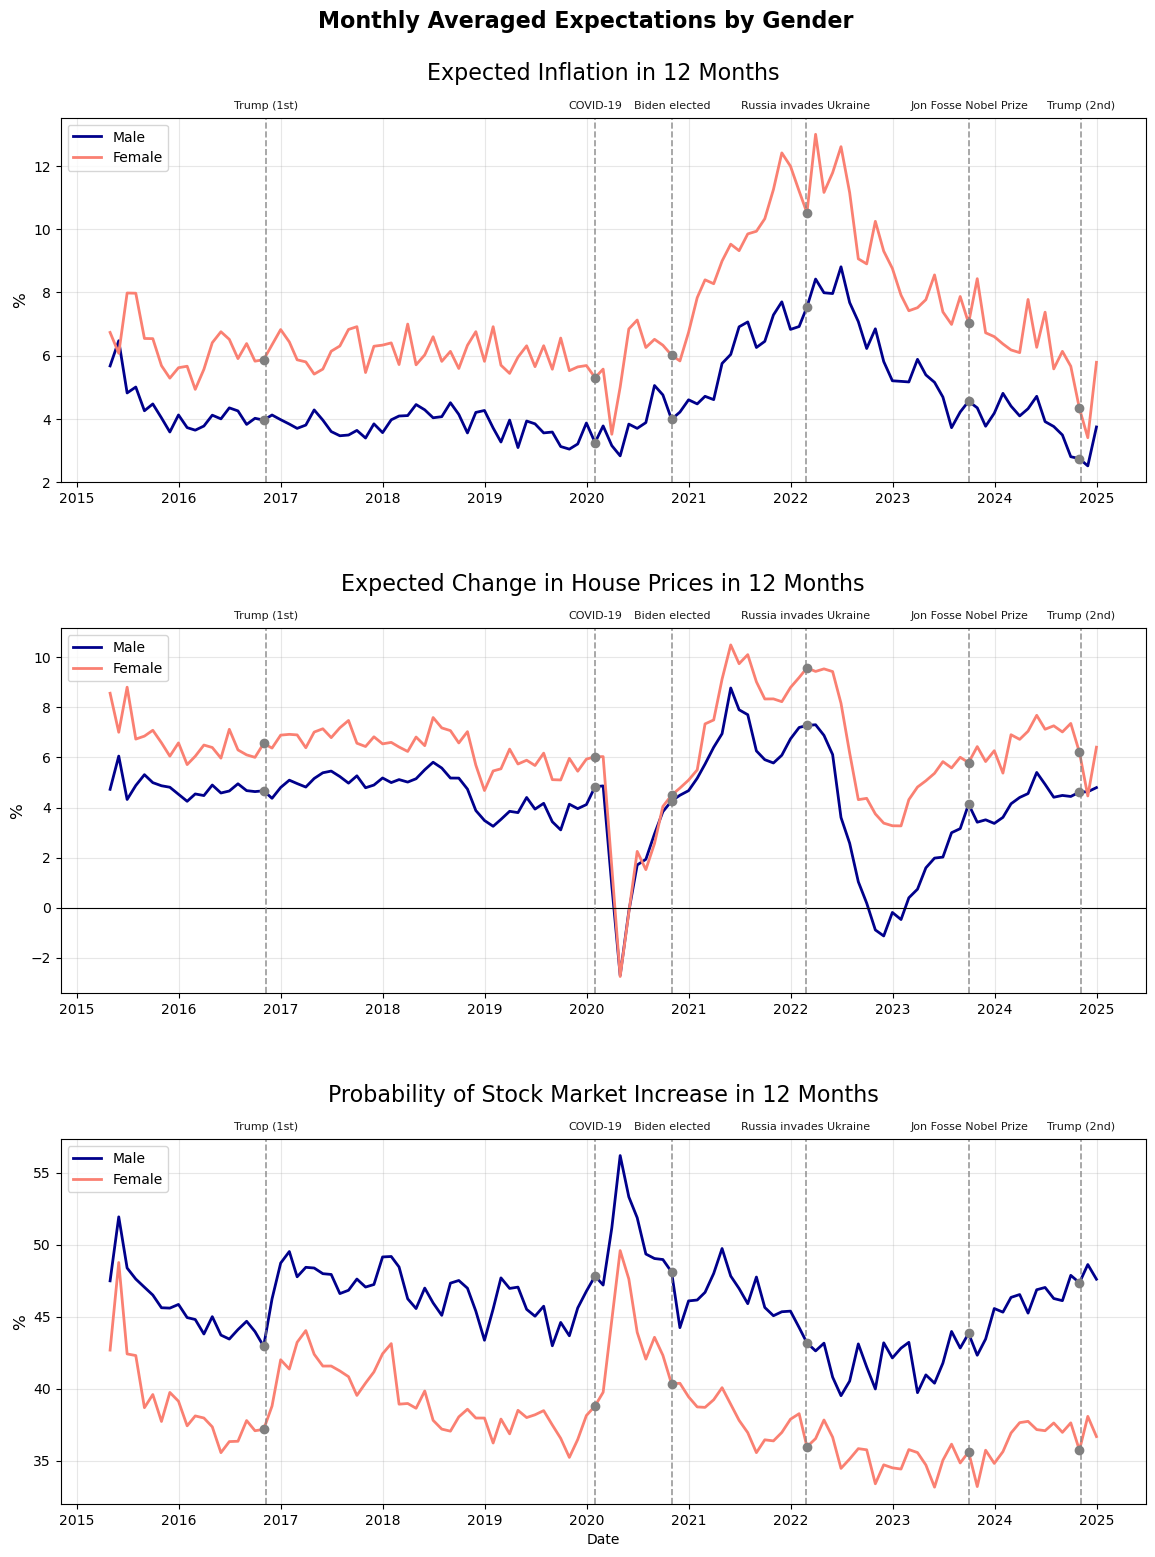

In [464]:
# Create monthly group plot for gender
fig, axes = create_monthly_group_plot(df, "female", ("Male", "Female"), "Monthly Averaged Expectations by Gender")

# Add event lines for the specific axes
add_event_lines(axes) 
   
plt.tight_layout()
plt.show()

#### Sub-Conclusion (Gender): 

Expectation dynamics differ clearly across gender, with women showing consistently higher expected inflation and stronger expected house price growth than men. This suggests that women are more price-sensitive and cautious about future conditions, while men display greater confidence in financial markets. The gender gap remains stable over time.

Global and political events amplify these differences. The COVID-19 pandemic in 2020 caused spikes in inflation expectations for both groups, but the increase was larger among men, possibly due to stronger reactions to short-term disruptions. House price expectations collapsed during the pandemic and rebounded sharply, particularly among women, reflecting quicker optimism toward economic recovery. The Russian invasion of Ukraine in 2022 reignited inflation fears and reduced optimism in housing markets, consistent with rising energy costs and global instability.

Political events caused smaller but visible shifts. Trump’s first election in 2016 raised stock market optimism, especially among men, reflecting confidence in deregulation and tax cuts. As the data ends in early 2025, reactions to his second term are not yet captured, though events such as Liberation Day in April 2025, when new tariffs were introduced, could have triggered similar effects. Biden’s 2020 election coincided with higher inflation and housing expectations, though likely driven by the post-COVID rebound rather than the election itself.

/var/folders/25/wpd8sltd5fl_pfs7dllz1bf40000gp/T/ipykernel_37081/3036565812.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


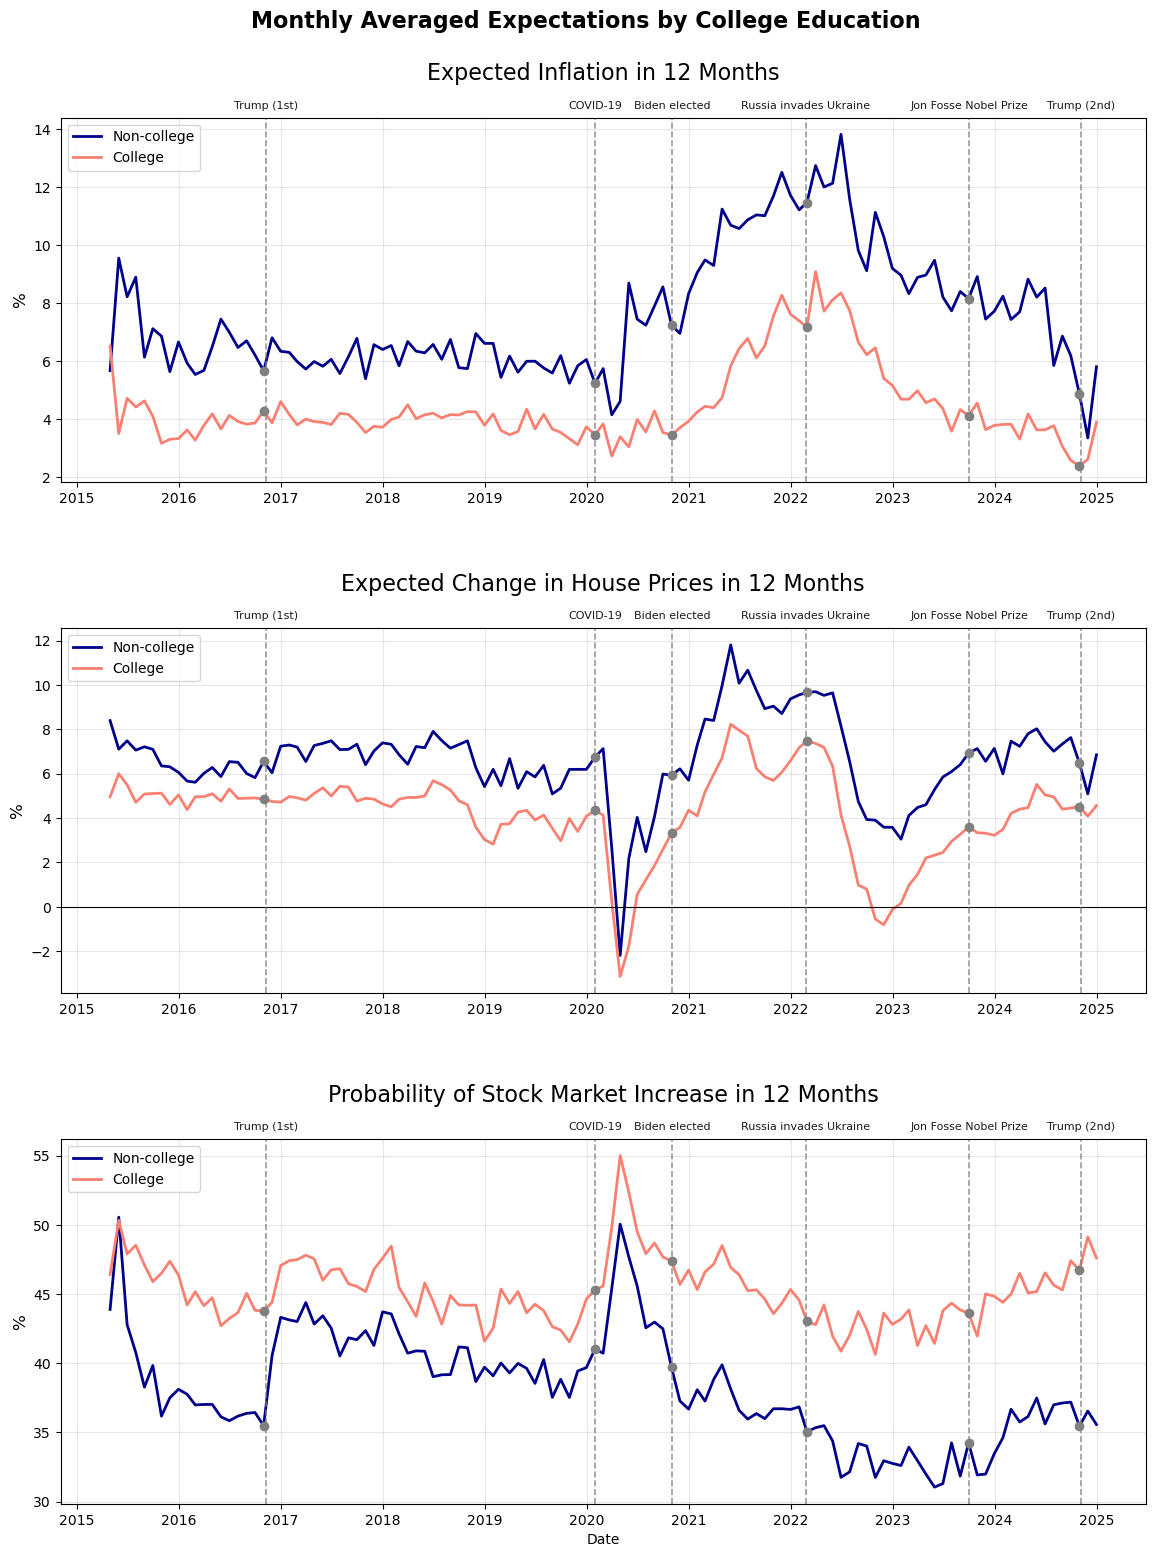

In [465]:
# Create monthly group plot for college education
fig, axes = create_monthly_group_plot(df, 'college', ('Non-college', 'College'), "Monthly Averaged Expectations by College Education")

# Add event lines for the specific axes
add_event_lines(axes)  
        
plt.tight_layout()
plt.show()

### Sub-Conclusion (Education level):
Overall, both groups move with the same shocks. 
Around Russia’s invasion, inflation expectations start to cool, house-price expectations roll over and plummet for both groups, and stock optimism drops while the Jon Fosse annotation shows no effect.
The differences are persistent where non-college respondents show higher and more volatile inflation expectations (including a large COVID-19 and peaks in 2021–22) and a deeper housing drop with a stronger rebound. On the other hand, college respondents  look more anchored.
 
When it comes to the probability of stock price increase, both groups optimism spikes around the introduction of the epidemic, and then falls sharply into 2022. However, college respondents are consistently more optimistic about a 12-month market rise (several percentage points higher most of the time), while non-college optimism is about 5-10 percentage points lower and drops and remains at a much lower level. These patterns are consistent with greater shock sensitivity among the non-college group, though the figures alone does not tell why.

/var/folders/25/wpd8sltd5fl_pfs7dllz1bf40000gp/T/ipykernel_37081/1750637315.py:7: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


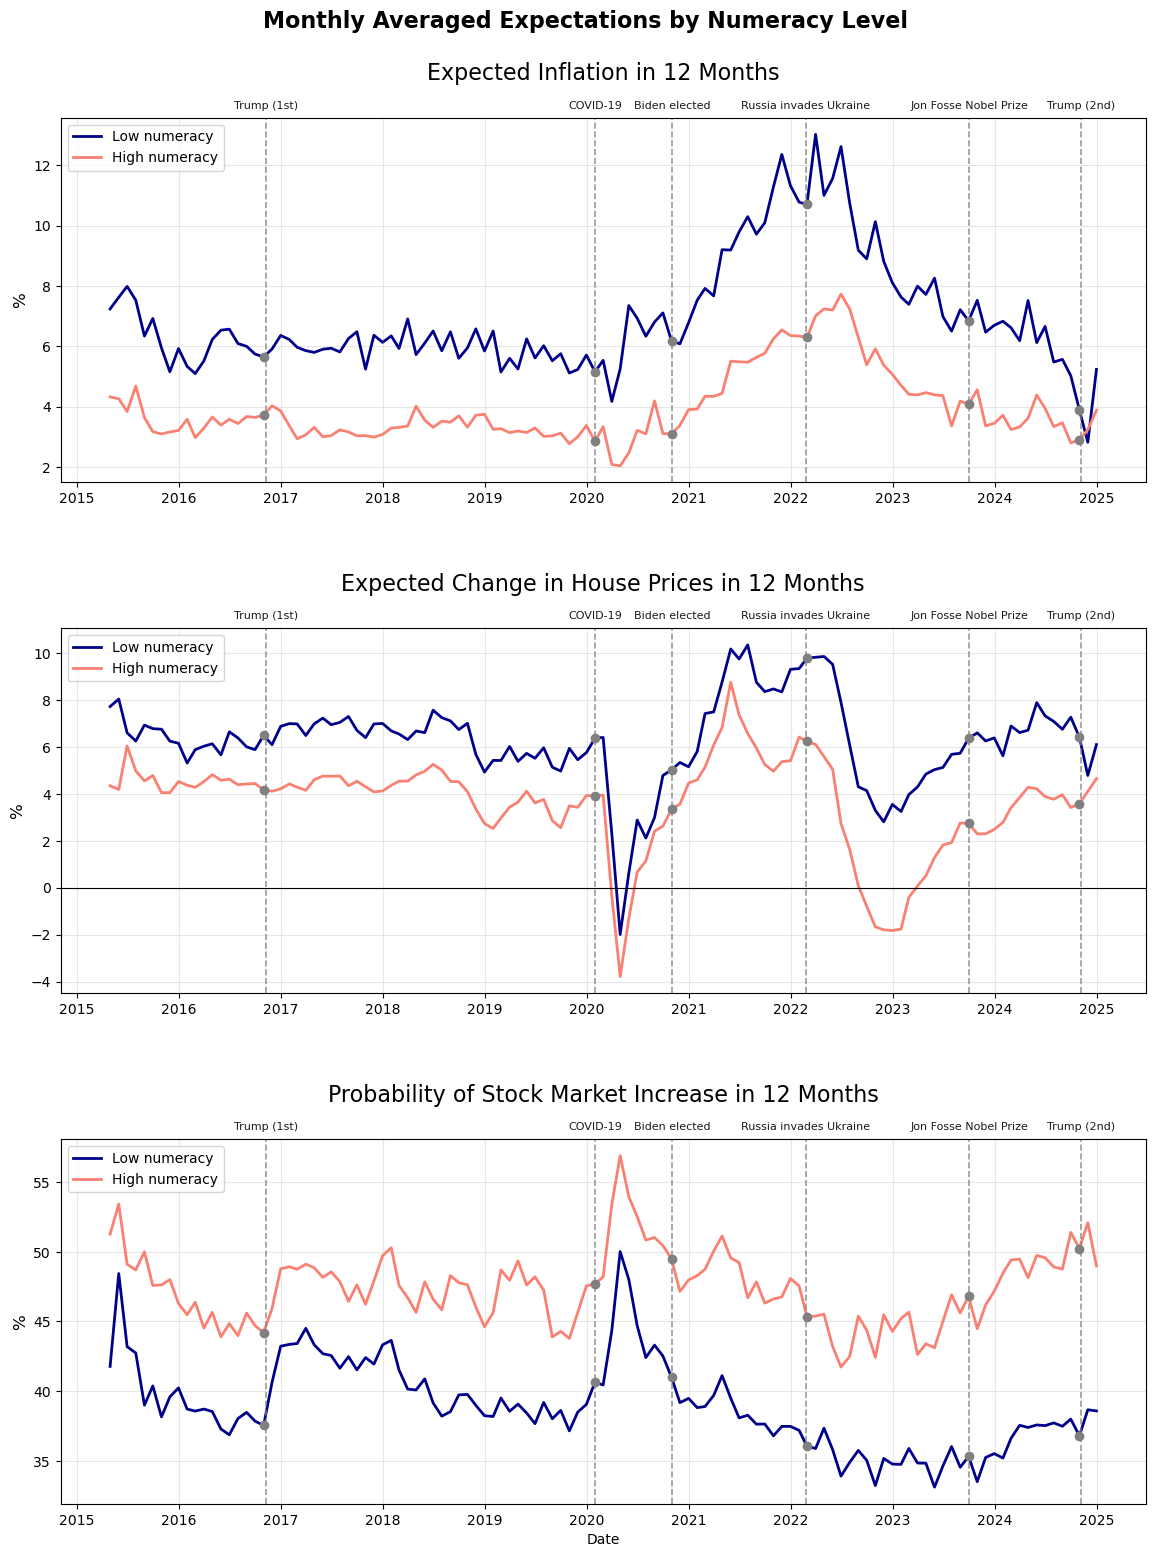

In [466]:
# Create monthly group plot for numerical literacy
fig, axes = create_monthly_group_plot(df, 'num_lit_high', ('Low numeracy', 'High numeracy'), "Monthly Averaged Expectations by Numeracy Level")

# Add event lines for the specific axes
add_event_lines(axes)          

plt.tight_layout()
plt.show()

### Sub-Conclusion (Numeracy-level):
Generally, the two most noticable effects are the epidemic and the russian invasion.
COVID-19 triggered an inflation spike, a housing plunge with a V-shaped rebound, and a brief surge in stock optimism. 

The 2022 invasion marks a turning point. The inflation expectations drops and cool, housing expectations roll over and fall into early-2023, and stock optimism drops. Elections in 2016, 2020, 2024 have minor effects, but are not clearly identifiable from background trends, while the Jon Fosse marker shows none.

Across adjustments, low-numeracy respondents run higher and more volatile on inflation (larger COVID-19 spike, higher 2021–22 peaks) and remain less pessimistic at the housing trough (rarely dipping below zero), whereas high-numeracy respondents are a bit more pessimistic on  housing during the downturn, but consistently more stock-optimistic. 

### Main Conclusion Part 4:
Gender:

Non college vs. college: 
Overall non-college shows more volatile inflation and house-price expectations, and a lower stock-market optimism. College respondents are in general more moderate on housing and inflation, and consistently more optimistic on stocks.

Numeracy level:

The vertical markers at the graphs are guides and not necessarily directly correlatedi with surges/downfall . Several moves start before or unfold after events. Attributing effects without a counterfactual (e.g., difference-in-differences) would be storytelling, which means that it is important to be cautious. 
Overall conclusion:
These are descriptive, event-timed patterns rather than causal estimates.

# Part 5
Are expectations correlated with the actual outcomes, or are individuals more likely to extrapolate
from past experiences?

In [ ]:
# Importing CPI.csv file using the previously defined function
df_cpi = importing_csvs('CPI', 'csv', ',', 'DATE')

In [468]:
def prepare_cpi_inflation(df_cpi, mode='future'):
    """
    Calculate inflation metrics from CPI data.
    
    Parameters:
    - df_cpi: DataFrame with 'DATE' and 'CPI' columns
    - mode: 'future' for realized inflation (CPI[t+12] vs CPI[t])
            'past' for past inflation (CPI[t] vs CPI[t-12])
    
    Returns:
    DataFrame with DATE and either 'Realized_Inflation' or 'Past_Inflation' column
    """
    df_result = df_cpi.copy()
    
    if mode == 'future':
        # Calculate realized inflation: compare current CPI to 12 months ahead
        df_result['CPI_12_ahead'] = df_result['CPI'].shift(-12)
        df_result['Realized_Inflation'] = (((df_result['CPI_12_ahead'] - df_result['CPI']) / df_result['CPI']) * 100) - 1
        df_result = df_result[['DATE', 'Realized_Inflation']].dropna().copy()
        
    elif mode == 'past':
        # Calculate past inflation: compare current CPI to 12 months ago
        df_result['CPI_12_ahead'] = df_result['CPI'].shift(12)
        df_result['Past_Inflation'] = (((df_result['CPI'] - df_result['CPI_12_ahead']) / df_result['CPI_12_ahead']) * 100) - 1
        df_result = df_result[['DATE', 'Past_Inflation']].dropna().copy()
        
    else:
        raise ValueError("mode must be either 'future' or 'past'")
    
    return df_result


In [469]:
def df_cpi_merge_by_group(df_cpi, group_col, Name_column_1, Name_column_2, mode):
    """
    Merge CPI inflation data with monthly group means.
    
    Parameters:
    - df_cpi: DataFrame from prepare_cpi_inflation with DATE and inflation column
    - group_col: string, column name for grouping ('female', 'college', 'num_lit_high')
    - Name_column_1: string, label for first group (e.g., 'Male')
    - Name_column_2: string, label for second group (e.g., 'Female')
    
    Returns:
    DataFrame with DATE as index, group expectations, and realized/past inflation
    """

    df_cpi = prepare_cpi_inflation(df_cpi, mode)

    # Get monthly group means for inflation expectations
    df_monthly_grouped = (monthly_group_means(df, group_col)[0]
                         .rename_axis('DATE')
                         .reset_index()
                         .rename(columns={0: Name_column_1, 1: Name_column_2}))

    # Shift monthly dates to beginning of month for merging
    df_monthly_grouped['DATE'] = df_monthly_grouped['DATE'] + pd.offsets.MonthBegin(1)

    # Merge with CPI data
    merged_inflation = (pd.merge(df_monthly_grouped, df_cpi, on='DATE', how='inner')
                        .set_index('DATE')
                        .sort_index())

    return merged_inflation

In [ ]:
df_female_future = df_cpi_merge_by_group(df_cpi, 'female', 'Male', 'Female', 'future')

,Male,Female,Realized_Inflation
DATE,,,
2015-05-01,5.676543,6.734328,0.097046
2015-06-01,6.471429,6.076271,0.051746
2015-07-01,4.822513,7.980000,-0.117647
2015-08-01,5.009677,7.973558,0.050420
2015-09-01,4.260068,6.543852,0.557895
...,...,...,...
2024-04-01,4.097288,6.096318,1.332268
2024-05-01,4.325465,7.775960,1.395401
2024-06-01,4.717261,6.264078,1.682849


In [476]:
def plot_realized_vs_expected(merged_df_grouped, mode, title):
    """
    Create a figure with two panels (one per gender), each showing a scatter plot of realized
    or past inflation (y-axis) versus average expected inflation by gender.
    Compute the correlation between expected and realized/past inflation for each gender and add
    the correlation coefficient as text to the corresponding panel.
    
    Parameters:
    - merged_df_grouped: DataFrame from df_cpi_merge_by_group
    - mode: 'future' for realized inflation or 'past' for past inflation
    - title: string for the overall plot title
    """
    # Determine the inflation column name based on mode
    inflation_col_name = 'Realized_Inflation' if mode == 'future' else 'Past_Inflation'
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle(title, fontsize=16, weight='bold')
    
    for i, gender in enumerate(['Male', 'Female']):
        ax = axes[i]
        x = merged_df_grouped[gender]
        y = merged_df_grouped[inflation_col_name]
        ax.scatter(x, y, alpha=0.6, color='darkblue' if gender == 'Male' else 'salmon')
        ax.set_title(f'{gender}', fontsize=14)
        ax.set_xlabel('Expected Inflation (%)', fontsize=12)
        ax.set_ylabel(f'{"Realized" if mode == "future" else "Past"} Inflation (%)', fontsize=12)
    
        # Calculate correlation coefficient
        corr_coef = np.corrcoef(x, y)[0, 1]

        # Add correlation coefficient as text to the plot
        ax.text(0.05, 0.95, f'Correlation: {corr_coef:.2f}',
                transform=ax.transAxes,
                fontsize=12,
                verticalalignment='top',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))
    plt.tight_layout()
    plt.show()  
    return None


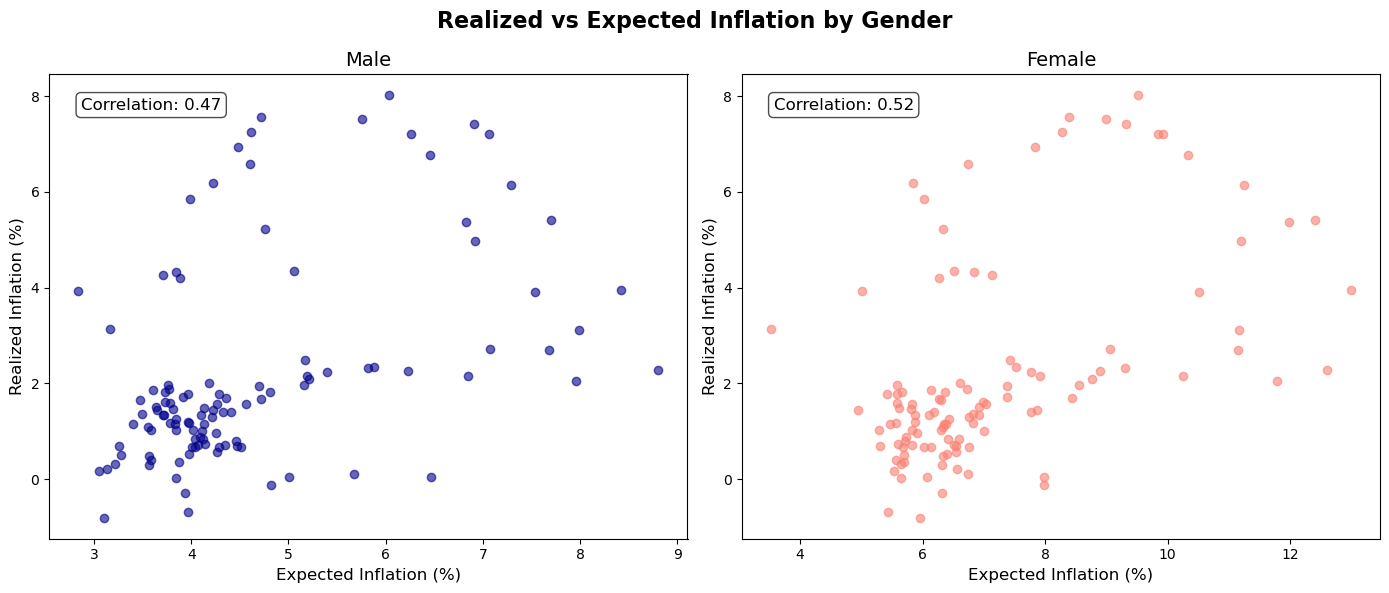

In [479]:
plot_realized_vs_expected(df_cpi_merged_female, 'future', 'Realized vs Expected Inflation by Gender')

# Task 5.2

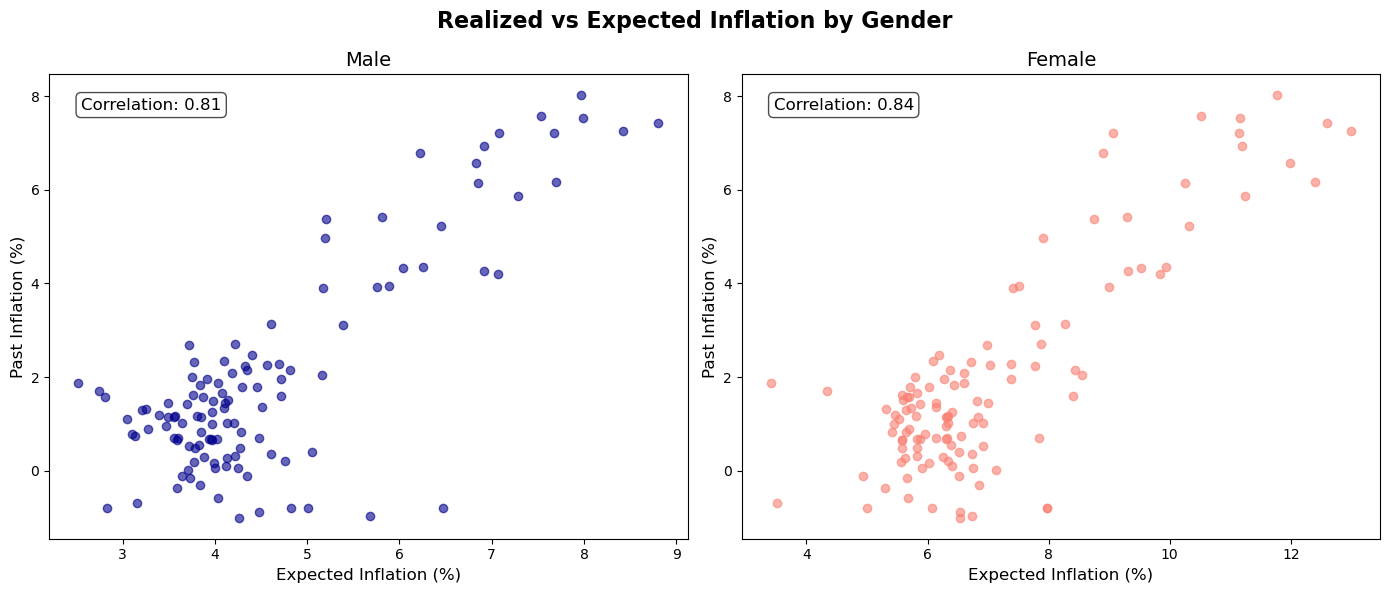

In [484]:
df_female_past = df_cpi_merge_by_group(df_cpi, 'female', 'Male', 'Female', 'past')
plot_realized_vs_expected(df_female_past, 'past', 'Realized vs Expected Inflation by Gender')

### Conclusion
From the scatter plots, it can be observed that the correlation between realized inflation and expected inflation was relatively low for both men and women, with values of 0.47 and 0.52 respectively. This indicates that candidates’ inflation expectations did not strongly align with the actual outcomes. The slightly higher correlation among women suggests that their predictions were somewhat more accurate compared to those of men.

In contrast, the correlation between past inflation and expected inflation was considerably higher, at 0.81 for men and 0.84 for women. This strong relationship implies that both genders rely heavily on past inflation trends when forming their expectations about future inflation. Furthermore, the slightly higher correlation among women suggests that they depend somewhat more on historical data than men do.

Overall, these results indicate that individuals are more likely to base their expectations on past experiences rather than accurately forecasting future inflation outcomes. Women appear to be both more reliant on previous inflation patterns and slightly more precise in their future predictions.
